# Preprocess Poses

Given poses from OpenPose, preprocess them for the model to train on

## Import Libraries

In [2]:
%matplotlib inline

import os
import json
import cv2
import math
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Image
from scipy.ndimage import gaussian_filter1d
from scipy.signal import medfilt#2d
from scipy import signal

## Define Joint Relationships 

And other functions to help us draw our poses later

In [3]:
joint_to_limb_heatmap_relationship = [
    [1,8],   [1,2],   [1,5],   [2,3],   [3,4],
    [5,6],   [6,7],   [8,9],   [9,10],  [10,11],
    [8,12],  [12,13], [13,14], [1,0],   [0,15],
    [15,17], [0,16],  [16,18]]

colors = [
    [255, 0, 0], [255, 85, 0], [255, 170, 0], [255, 255, 0], [170, 255, 0],
    [85, 255, 0], [0, 255, 0], [0, 255, 85], [0, 255, 170], [0, 255, 255],
    [0, 170, 255], [0, 85, 255], [0, 0, 255], [85, 0, 255], [170, 0, 255],
    [255, 0, 255], [255, 0, 170], [255, 0, 85], [255, 0, 0], [255,0,0],
    [255,0,0], [255,0,0], [255,0,0], [255,0,0]]


def imshow(image):
    plt.imshow(image[:,:,[2,1,0]].astype(np.uint8))
    plt.show()

def add_pose_to_canvas(person_id, coors, canvas, limb_thickness=4):
    limb_type = 0
    labeled = False
    for joint_relation in  joint_to_limb_heatmap_relationship: # [1, 8] for example
        joint_coords = coors[joint_relation] # use it as indices 
        if 0 in joint_coords: # if a keypoint has 0
            # ignore keypoints that are not predicted
            limb_type += 1
            continue
        for joint in joint_coords:  # Draw circles at every joint
            if not labeled:
                font = cv2.FONT_HERSHEY_SIMPLEX
                cv2.putText(canvas, person_id,
                            tuple(joint[0:2].astype(int)), font,
                            2, (0,0,0), thickness=5)
                labeled = True
            cv2.circle(canvas, tuple(joint[0:2].astype(
                        int)), 4, (0,0,0), thickness=-1)
        coords_center = tuple(
                    np.round(np.mean(joint_coords, 0)).astype(int))
        limb_dir = joint_coords[0, :] - joint_coords[1, :]
        limb_length = np.linalg.norm(limb_dir)
        angle = math.degrees(math.atan2(limb_dir[1], limb_dir[0]))
        polygon = cv2.ellipse2Poly(
                    coords_center, (int(limb_length / 2), limb_thickness), int(angle), 0, 360, 1)
        cv2.fillConvexPoly(canvas, polygon, colors[limb_type])
        limb_type += 1
    return canvas

    
def draw_pose_figure(person_id, coors, height=1500, width=1500, limb_thickness=4):
    canvas = np.ones([height,width,3])*255
    canvas = canvas.astype(np.uint8)
    limb_type = 0
    return add_pose_to_canvas(person_id, coors, canvas, limb_thickness)


## Get the relevant input and output directories

Input dir should be directory of json files containing pose info

Output_dir will be directory we save the final json to

In [4]:
input_dir = '/Users/will.i.liam/Desktop/final_project/openpose/output/'
output_dir = '/Users/will.i.liam/Desktop/final_project/phoan/images/'
json_files = [pos_json for pos_json in os.listdir(input_dir) if 
              pos_json.endswith('.json')]

json_files = sorted(json_files)

In [5]:
frame = 376

## Either allow the user to specify which pose to pick per frame, or use distance algorithm to determine the next most similar pose to the current one

In [6]:
def distance(key_a, key_b, conf_a, conf_b):
    confs = conf_a * conf_b > 0
    confs = confs.reshape(-1, 1)
    
    return np.sum(((key_a - key_b)**2)*(confs)) / np.sum(confs)

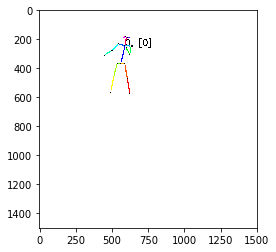

In [173]:
# normalized the landmark coordinates within each frame, 
# by subtracting a reference landmark (the neck) 
# and dividing by a reference distance (the trunk length)

def normalize_in_frame(frame):
    """
    expects frame in the order of openpose outputs
    [21, 2] where 2 corresponds to x- y- coordinates
    
    reduces the pixel coordinate size of each coordinate
    """
    neck = frame[1]
    subtracted = frame - neck
    trunk_length = np.sqrt(np.sum( (subtracted[8] - subtracted[1]) ** 2))
    divided = frame / trunk_length
    return divided

def adjust_to_canvas(poses):
    poses = poses * 125
    return poses, np.ones([np.int(poses[8][1] * 2),
                    np.int(poses[8][0] * 2), 3]) * 255

frame = 2000
data = json.load(open(input_dir + json_files[frame]))
person_1 = 0
person_id_1 = str(person_1) + ", " + str(data['people'][person_1]['person_id'])
a_keys_and_confs = np.array(data['people'][person_1]['pose_keypoints_2d']).reshape(-1, 3)
# normalized
divided = normalize_in_frame(a_keys_and_confs[:, :2])
adjusted_poses = divided * 125
canvas = draw_pose_figure(person_id_1, 
                          adjusted_poses)
results = np.hstack([divided, a_keys_and_confs[:, :2]])
imshow(canvas)

Take in frames 370 - 670 of p_hoan: at 30 fps, 300 frames adds up to around 10 seconds of video

In [7]:
frames = np.arange(370, 670)
data = []

for frame in frames:
    poses = json.load(open(input_dir + json_files[frame]))
    data.append(poses['people'][0])

keys_and_confs_per_frame = []
for datum in data:
    keys_and_confs_per_frame.append(np.array(datum['pose_keypoints_2d']).reshape(-1, 3))

canvases = []
for keys_and_confs in keys_and_confs_per_frame:
    person_id = str(0) + ", " + str([0])
    canvases.append(draw_pose_figure(person_id,
                                    keys_and_confs[:, :2]))

In [519]:
output_filename = 'longer_pre_smoothing.mp4'
height, width, layers = canvases[0].shape
size = (width,height)

fourcc_format = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter(output_filename, fourcc_format, 30, size)
 
for i in range(len(canvases)):
    out.write(canvases[i])
out.release()


In [520]:
# keys_and_confs_per_frame = []
# an array of multiple 21 x 3
np_keys_and_confs_per_frame = np.array(keys_and_confs_per_frame)
smoothed = np.copy(np_keys_and_confs_per_frame)
print(smoothed.shape)

(300, 21, 3)


In [529]:
smoothed_no_interp = np.copy(np_keys_and_confs_per_frame)
window_length, polyorder = 13, 2

# kernel = cv2.getGaussianKernel(ksize=(1,1),sigma=2)
# kernel = np.transpose(kernel)
# oneD = cv2.filter2D(imgIn, -1, kernel)

# or use GaussianBlur
# cv2.GaussianBlur(src, ksize, sigmaX[, dst[, sigmaY[, borderType]]])
# cv2.GaussianBlur(src, ksize=(1,1))

# we need our dataset in the order of (frame, body part, x- y-coordinates)
# iterate through all frames, isolate body part and x- y- coordinate
for i in range(21): # evaluate per body part
    # x or y coordinate
    for j in range(2):
        a_slice = np_keys_and_confs_per_frame[:, i, j]
        orig_shape = a_slice.shape
        a_slice = a_slice.reshape(-1)
        # smoothed_slice = gaussian_filter1d(a_slice, 100)
        med_filtered_slice = medfilt(a_slice)
        # smoothed_slice = signal.savgol_filter(med_filtered_slice, window_length, polyorder)
        smoothed_slice = cv2.GaussianBlur(med_filtered_slice, (7, 7), 100)
        smoothed_no_interp[:, i, j] = smoothed_slice.reshape(orig_shape)

In [530]:
smoothed_no_interp_canvases = []
for smoothed_keys_and_confs in smoothed_no_interp:
    person_id = str(0) + ", " + str([0])
    smoothed_no_interp_canvases.append(draw_pose_figure(person_id,
                                                        smoothed_keys_and_confs[:, :2]))

In [531]:
output_filename = 'longer_smoothing_no_interp.mp4'
height, width, layers = smoothed_no_interp_canvases[0].shape
size = (width,height)

fourcc_format = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter(output_filename, fourcc_format, 30, size)
 
for i in range(len(smoothed_no_interp_canvases)):
    out.write(smoothed_no_interp_canvases[i])
out.release()

note that their example is just x position and velocity
but we'll need x position y position and x velocity y velocity

In [440]:
copy = np.copy(np_keys_and_confs_per_frame)
original = copy[5, 3, 0]
np_keys_and_confs_per_frame[5, 3, 0] = 0

missing_coord = 0
frames = np.where(np_keys_and_confs_per_frame[:, 3, 0] != 0)[0]
actual_coords = [0]
print(np_keys_and_confs_per_frame[:, 3, 0])
interpolated_x = np.interp(np.arange(30), frames, np_keys_and_confs_per_frame[:, 3, 0][frames])
interpolated_y = np.interp(np.arange(30), frames, np_keys_and_confs_per_frame[:, 3, 1][frames])
# apply Kalman
for i in range(30):
    x = interpolated_x[i]
    y = interpolated_y[i]
    print(KF(x, y, i+1))

[786.447 786.452 789.167 789.287 789.296   0.    795.251 798.09  806.872
 809.867 812.833 815.825 824.66  833.272 836.353 839.401 851.057 857.055
 862.935 877.518 883.611 898.142 907.043 915.888 927.642 933.566 948.147
 954.081 962.932 974.76 ]
None
[786.4519800796812, 433.0300199203187]
[789.1562259410919, 433.10370642361386]
[789.2904079361014, 433.16202008834125]
[789.2996213950498, 433.17810350181395]
[792.2887311893062, 430.1543797570764]
[795.2505361332397, 427.2132772143813]
[798.0886964696806, 424.3589319410451]
[806.7600288544443, 418.4937662053538]
[809.9028931582784, 415.4778822294915]
[812.864668314688, 412.69449536956967]
[815.9093996101677, 412.4900492983572]
[820.5354515932045, 407.7865097460192]
[836.80952845405, 416.55637775986224]
[835.1461931012581, 411.797695545889]
[839.1091284483192, 412.56057353737066]
[872.1458221643046, 399.28401999313564]
[860.2079669784197, 405.5822792015752]
[863.898782480542, 403.34078740516634]
[872.7428389785754, 396.1022685032807]
[881.6

In [527]:
smoothed = np.copy(np_keys_and_confs_per_frame)

for i in range(21): # evaluate per body part
    # x or y coordinate
    for j in range(2):
        a_slice = np_keys_and_confs_per_frame[:, i, j]
        orig_shape = a_slice.shape
        a_slice = a_slice.reshape(-1)
        
        frames = np.where(a_slice != 0)[0]
        interpolated = np.interp(np.arange(orig_shape[0]), frames, a_slice[frames])
        # smoothed_slice = gaussian_filter1d(a_slice, 100)
        med_filtered_slice = medfilt(interpolated)
        # smoothed_slice = signal.savgol_filter(med_filtered_slice, window_length, polyorder)
        smoothed_slice = cv2.GaussianBlur(med_filtered_slice, (7, 7), 100)
        smoothed[:, i, j] = smoothed_slice.reshape(orig_shape)

In [528]:
interpolated_canvases = []
for k_c in smoothed:
    person_id = str(0) + ", " + str([0])
    interpolated_canvases.append(draw_pose_figure(person_id,
                                                  k_c[:, :2]))
    
output_filename = 'longer_smoothed_interp.mp4'
height, width, layers = interpolated_canvases[0].shape
size = (width,height)

fourcc_format = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter(output_filename, fourcc_format, 30, size)
 
for i in range(len(interpolated_canvases)):
    out.write(interpolated_canvases[i])
out.release()